# Изучение поведения пользователей мобильного приложения

<div class="alert alert-info" role="alert">
     
Наша задача разобраться, как ведут себя пользователи мобильного приложения в стартапе, который продаёт продукты питания.
Для этого требуется изучить воронку продаж и узнать, как пользователи доходят до покупки, сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах.
<b>Описание данных:</b>
    
Каждая запись в логе — это действие пользователя, или событие.
    
EventName — название события;

DeviceIDHash — уникальный идентификатор пользователя;
    
EventTimestamp — время события;
    
ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

<b>Шаг 1.  Откроем файл с данными и изучим общую информацию</b>

<b>Шаг 2. Подготовим данные</b>
    
Заменим названия столбцов;
    
Проверим пропуски и типы данных. Откорректируем, если нужно;
    
Добавим столбец даты и времени, а также отдельный столбец дат;    

<b>Шаг 3. Изучим и проверим данные</b>    

Постараемся ответить на следующие вопросы:
    
Сколько всего событий в логе
    
Сколько всего пользователей в логе
    
Сколько в среднем событий приходится на пользователя
    
Определим за какой период мы располагаем данными. Найдем максимальную и минимальную дату. Построим гистограмму по дате и времени. 
Определим, с какого момента данные полные и отбросим более старые.
    
Определим много ли событий и пользователей мы потеряли, отбросив старые данные.
Проверим, что у нас есть пользователи из всех трёх экспериментальных групп.    
    
<b>Шаг 4. Изучим воронку событий</b>    
    
Посмотрим, какие события есть в логах, как часто они встречаются. Отсортируем события по частоте.
    
Посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей. Посчитаем долю пользователей, которые хоть раз совершали событие.
    
Предположим, в каком порядке происходят события. Определим, все ли они выстраиваются в последовательную цепочку.
    
По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки.
    
Определим на каком шаге теряется больше всего пользователей.
    
Определим какая доля пользователей доходит от первого события до оплаты.
        
<b>Шаг 5. Изучим результаты эксперимента</b>   
       
Определим сколько пользователей в каждой экспериментальной группе.
    
Проверим, находят ли статистические критерии разницу между выборками 246 и 247.
    
Выберем самое популярное событие. Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп. 
    
Посчитаем долю пользователей, совершивших это событие. Проверим, будет ли отличие между группами статистически достоверным. 
    
Проверим, будет ли отличие между группами статистически достоверным с группой с изменённым шрифтом.
Сравним результаты с каждой из контрольных групп в отдельности по каждому событию. Сравним результаты с объединённой контрольной группой.
    
Посчитаем, сколько проверок статистических гипотез мы сделали..    
     
<b>Шаг 6. Сформулируем выводы и рекомендации</b>   

</div>

# Шаг 1. Откроем файл с данными и изучим общую информацию

In [167]:
import pandas as pd

import numpy as np
from matplotlib import pyplot as plt

import math
from scipy import stats

from datetime import datetime, timedelta

from statsmodels.stats.proportion import proportions_ztest
import warnings

warnings.filterwarnings('ignore')

In [168]:
data= pd.read_csv("/datasets/logs_exp.csv", sep="\t")
data.sample(10)

,EventName,DeviceIDHash,EventTimestamp,ExpId
158597,MainScreenAppear,7716966784740554487,1565010687,247
144753,MainScreenAppear,907516373885804773,1564985526,246
129545,PaymentScreenSuccessful,7980064927529100411,1564931613,247
173865,CartScreenAppear,2305766456715991733,1565032805,248
241069,PaymentScreenSuccessful,2438520924615884865,1565203620,246
51109,MainScreenAppear,2772044537339378962,1564740058,248
177731,PaymentScreenSuccessful,2808383095708030942,1565059344,246
146014,MainScreenAppear,4639223369107552273,1564988584,247
197517,CartScreenAppear,3337471580007169353,1565100641,246
63927,CartScreenAppear,4835794310804404208,1564760639,246


### Проверим пропуски и типы данных и т.д.

In [169]:
data.duplicated().sum()

413

In [170]:
print('Процент дубликатов в датасете: {:.2%}'.format(data.duplicated().sum() / data['DeviceIDHash'].count()))

Процент дубликатов в датасете: 0.17%


В датасете 413 дубликатов или 0.17%. Удалим их.

In [171]:
data = data.drop_duplicates().reset_index(drop=True) 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 4 columns):
EventName         243713 non-null object
DeviceIDHash      243713 non-null int64
EventTimestamp    243713 non-null int64
ExpId             243713 non-null int64
dtypes: int64(3), object(1)
memory usage: 7.4+ MB


Таблица заполненна полностью. Все столбцы соответствуют своему типу. 

In [172]:
data['ExpId'].unique()

array([246, 248, 247])

In [173]:
data['EventName'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

<b>Шаг 1. Вывод:</b>

Данные представляют собой около 244 тысячи строк.

Столбец ExpId состоит из 3-х значений экспериментов: 246 и 247 — контрольные группы, а 248 — экспериментальная.

Столбец EventName (название события) включает в себя следующие данные:

CartScreenAppear - Переход на экран корзины;

MainScreenAppear - Переход на главный экран;

OffersScreenAppear - Переход на экран предложений;

PaymentScreenSuccessful - Успешное совершение платежа;

Tutorial - Руководство.

# Шаг 2. Подготовим данные

### Заменим названия столбцов

In [174]:
data.columns = ['event_name', 'device_id_hash', 'event_timestamp', 'exp_id']
data

,event_name,device_id_hash,event_timestamp,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
243708,MainScreenAppear,4599628364049201812,1565212345,247
243709,MainScreenAppear,5849806612437486590,1565212439,246
243710,MainScreenAppear,5746969938801999050,1565212483,246
243711,MainScreenAppear,5746969938801999050,1565212498,246


### Добавим столбец даты и времени, а также отдельный столбец дат

In [175]:
data['event_time_sec'] = pd.to_datetime(data['event_timestamp'], unit='s', origin='unix') 
data

,event_name,device_id_hash,event_timestamp,exp_id,event_time_sec
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42
...,...,...,...,...,...
243708,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 21:12:25
243709,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 21:13:59
243710,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 21:14:43
243711,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 21:14:58


In [176]:
data['event_time_day'] = data['event_time_sec'].dt.day
data

,event_name,device_id_hash,event_timestamp,exp_id,event_time_sec,event_time_day
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,25
...,...,...,...,...,...,...
243708,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 21:12:25,7
243709,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 21:13:59,7
243710,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 21:14:43,7
243711,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 21:14:58,7


<b>Шаг 2. Вывод:</b>

Для удобства мы привели названия столбцов датасета к ниднему регистру и разделили названия через "_". Определили время для каждого события и записали его в столбец event_time_sec. Выделили дату каждого события в столбец event_time_day.

# Шаг 3. Изучим и проверим данные

### Определим сколько всего событий в логе

In [177]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 6 columns):
event_name         243713 non-null object
device_id_hash     243713 non-null int64
event_timestamp    243713 non-null int64
exp_id             243713 non-null int64
event_time_sec     243713 non-null datetime64[ns]
event_time_day     243713 non-null int64
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 11.2+ MB


In [178]:
stat_event = data.pivot_table(index="event_name", values="exp_id", aggfunc = 'count')
stat_event

,exp_id
event_name,
CartScreenAppear,42668
MainScreenAppear,119101
OffersScreenAppear,46808
PaymentScreenSuccessful,34118
Tutorial,1018


В нашем датасете всего 243713 события.
Из них:

Переход на экран корзины - 42668 события;

Переход на главный экран - 119101 события;

Переход на экран предложений - 46808 события;

Успешное совершение платежа - 34118 события;

Изучение руководства - 1018 событий.

In [179]:
stat_exp_id = data.pivot_table(index="exp_id", values="event_name", aggfunc = 'count')
stat_exp_id

,event_name
exp_id,
246,80181
247,77950
248,85582


Разделенные на 3 группы пользователи совершают примерно равное число событий: Группа А - 80181 событий, контрольная группа А - 77950 событий и группа В - 85582 событий.

### Сколько всего пользователей в логе

In [180]:
data['device_id_hash'].value_counts()

6304868067479728361    2307
197027893265565660     1998
4623191541214045580    1768
6932517045703054087    1439
1754140665440434215    1221
                       ... 
3336727186673646149       1
1657967711232741323       1
425817683219936619        1
4089770943116790924       1
1083512226259476085       1
Name: device_id_hash, Length: 7551, dtype: int64

Всего у нас 7551 пользователь с числом событий от 1 до 2307. 

### Сколько в среднем событий приходится на пользователя

In [181]:
data['device_id_hash'].value_counts().head(10)

6304868067479728361    2307
197027893265565660     1998
4623191541214045580    1768
6932517045703054087    1439
1754140665440434215    1221
3337471580007169353    1186
7738058666231999878     888
1055544042902443290     854
4713748699910253089     824
8118046800480174342     755
Name: device_id_hash, dtype: int64

In [182]:
data['device_id_hash'].value_counts().mean().round(0)

32.0

In [183]:
data['device_id_hash'].value_counts().median()

20.0

В среднем на одного пользователя приходится 20 событий, медианное значение сотавляет 32 события. Скорее всего в данных есть выбросы. Изучим поведение пользователя в дальнейший действиях.

### Определим за какой период мы располагаем данными. Найдем максимальную и минимальную дату. Построим гистограмму по дате и времени. 

In [184]:
data['event_time_sec'].min()

Timestamp('2019-07-25 04:43:36')

In [185]:
data['event_time_sec'].max()

Timestamp('2019-08-07 21:15:17')

Начало данных с 25 июля 2019 года, окончание 07 августа 2019 года, что составляет 2 недели.

Посмотрим как распределены данные за этот период. остроим гистограммы

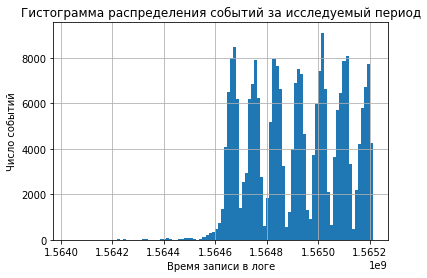

In [186]:
data.hist('event_timestamp', bins=100)
plt.title('Гистограмма распределения событий за исследуемый период')
plt.xlabel('Время записи в логе')
plt.ylabel('Число событий');

В начале исследуевого периода идет низкая активность пользователей.

Посмотрим на пользователей и их активность до 1 августа

In [187]:
anomaly = data.query('event_time_day > 7')
anomaly

,event_name,device_id_hash,event_timestamp,exp_id,event_time_sec,event_time_day
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,25
...,...,...,...,...,...,...
2821,OffersScreenAppear,2413191300976302222,1564617295,247,2019-07-31 23:54:55,31
2822,MainScreenAppear,5505110279185484837,1564617450,247,2019-07-31 23:57:30,31
2823,MainScreenAppear,5505110279185484837,1564617462,247,2019-07-31 23:57:42,31
2824,MainScreenAppear,5505110279185484837,1564617472,247,2019-07-31 23:57:52,31


In [188]:
anomaly_id_hash = anomaly['device_id_hash'].value_counts().reset_index()
anomaly_id_hash

,index,device_id_hash
0,1076256040994094004,39
1,3807928414254040303,32
2,5505110279185484837,29
3,3732189810952196067,22
4,5224056977998049474,22
...,...,...
1446,789235048114585398,1
1447,3978977709753461804,1
1448,1535501606752467083,1
1449,7244344893422246761,1


Посмотрим на случайных пользователей из данной выборки

In [189]:
anomaly_1 = data.query('device_id_hash == 1076256040994094004')
anomaly_1

,event_name,device_id_hash,event_timestamp,exp_id,event_time_sec,event_time_day
1018,MainScreenAppear,1076256040994094004,1564567226,248,2019-07-31 10:00:26,31
1020,MainScreenAppear,1076256040994094004,1564567654,248,2019-07-31 10:07:34,31
1021,MainScreenAppear,1076256040994094004,1564567712,248,2019-07-31 10:08:32,31
1024,MainScreenAppear,1076256040994094004,1564567753,248,2019-07-31 10:09:13,31
1025,MainScreenAppear,1076256040994094004,1564567769,248,2019-07-31 10:09:29,31
...,...,...,...,...,...,...
241584,MainScreenAppear,1076256040994094004,1565205338,248,2019-08-07 19:15:38,7
241601,MainScreenAppear,1076256040994094004,1565205372,248,2019-08-07 19:16:12,7
241618,MainScreenAppear,1076256040994094004,1565205412,248,2019-08-07 19:16:52,7
241805,MainScreenAppear,1076256040994094004,1565205722,248,2019-08-07 19:22:02,7


In [190]:
anomaly_2 = data.query('device_id_hash == 5148222703557502114')
anomaly_2

,event_name,device_id_hash,event_timestamp,exp_id,event_time_sec,event_time_day
597,MainScreenAppear,5148222703557502114,1564495874,246,2019-07-30 14:11:14,30
23385,OffersScreenAppear,5148222703557502114,1564668933,246,2019-08-01 14:15:33,1
23399,OffersScreenAppear,5148222703557502114,1564668951,246,2019-08-01 14:15:51,1
23788,MainScreenAppear,5148222703557502114,1564669458,246,2019-08-01 14:24:18,1
25176,OffersScreenAppear,5148222703557502114,1564671301,246,2019-08-01 14:55:01,1
25194,PaymentScreenSuccessful,5148222703557502114,1564671312,246,2019-08-01 14:55:12,1
25196,CartScreenAppear,5148222703557502114,1564671313,246,2019-08-01 14:55:13,1
68911,MainScreenAppear,5148222703557502114,1564769463,246,2019-08-02 18:11:03,2
68916,OffersScreenAppear,5148222703557502114,1564769471,246,2019-08-02 18:11:11,2
68940,OffersScreenAppear,5148222703557502114,1564769523,246,2019-08-02 18:12:03,2


In [191]:
anomaly_3 = data.query('device_id_hash == 7540130374989658208')
anomaly_3

,event_name,device_id_hash,event_timestamp,exp_id,event_time_sec,event_time_day
17,MainScreenAppear,7540130374989658208,1564144283,248,2019-07-26 12:31:23,26
55050,MainScreenAppear,7540130374989658208,1564746729,248,2019-08-02 11:52:09,2
55158,MainScreenAppear,7540130374989658208,1564746875,248,2019-08-02 11:54:35,2
55227,MainScreenAppear,7540130374989658208,1564747028,248,2019-08-02 11:57:08,2
55598,MainScreenAppear,7540130374989658208,1564747771,248,2019-08-02 12:09:31,2
223487,MainScreenAppear,7540130374989658208,1565173900,248,2019-08-07 10:31:40,7
223548,MainScreenAppear,7540130374989658208,1565173997,248,2019-08-07 10:33:17,7
223551,MainScreenAppear,7540130374989658208,1565173999,248,2019-08-07 10:33:19,7
223557,MainScreenAppear,7540130374989658208,1565174009,248,2019-08-07 10:33:29,7


In [192]:
anomaly_4 = data.query('device_id_hash == 4575588528974610257')
anomaly_4

,event_name,device_id_hash,event_timestamp,exp_id,event_time_sec,event_time_day
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,25
4579,MainScreenAppear,4575588528974610257,1564633800,246,2019-08-01 04:30:00,1
108403,MainScreenAppear,4575588528974610257,1564888031,246,2019-08-04 03:07:11,4
108405,OffersScreenAppear,4575588528974610257,1564888070,246,2019-08-04 03:07:50,4
108408,MainScreenAppear,4575588528974610257,1564888143,246,2019-08-04 03:09:03,4
108410,MainScreenAppear,4575588528974610257,1564888203,246,2019-08-04 03:10:03,4
108414,MainScreenAppear,4575588528974610257,1564888262,246,2019-08-04 03:11:02,4
108415,MainScreenAppear,4575588528974610257,1564888306,246,2019-08-04 03:11:46,4
111075,MainScreenAppear,4575588528974610257,1564899761,246,2019-08-04 06:22:41,4
111732,MainScreenAppear,4575588528974610257,1564901643,246,2019-08-04 06:54:03,4


Скорее всего малоактивный период до 1 августа связан с тем, что в выборки попали пользователи, которые раньше начали пользоваться нашим приложение. Поскольку их доля оказалась невелика, то и активность на общем фоне выглядит малой.

Исследуем активный период данных.

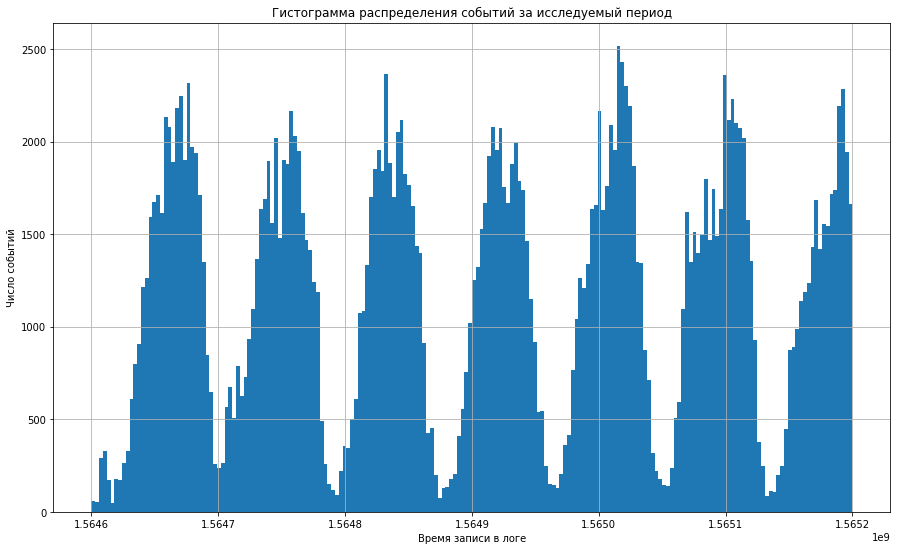

In [193]:
data.hist('event_timestamp', bins=200, range=(1564600000, 1565200000), figsize=(15, 9))
plt.title('Гистограмма распределения событий за исследуемый период')
plt.xlabel('Время записи в логе')
plt.ylabel('Число событий');

Данные несут периодический характер, прослеживаются циклическая активность связанная с суточной периодичностью (день/ночь). За последний день данные немного урезаны. Посмотрим на дневном графике распределения событий, на сколько у нас меняются эти данные в сутки

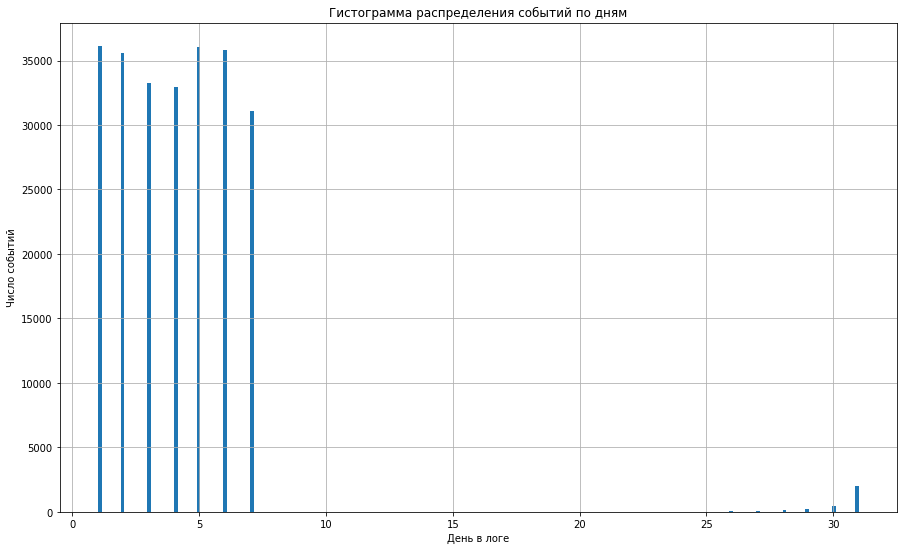

In [194]:
data.hist('event_time_day', bins=200, figsize=(15, 9))
plt.title('Гистограмма распределения событий по дням')
plt.xlabel('День в логе')
plt.ylabel('Число событий');

У нас представленны данные в основном за 7 дней. За последный день данные немного обрезаны, но это не сильно влияет на суточные показатели активности. 

### Определим много ли событий и пользователей мы потеряли, отбросив старые данные

Отбросим данные которые не попали в наш активный период с 1 по 7 день августа 2019 года

In [195]:
df = data.query('event_time_day >= 1' and 'event_time_day <= 7')
df

,event_name,device_id_hash,event_timestamp,exp_id,event_time_sec,event_time_day
2826,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,1
2827,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,1
2828,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,1
2829,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,1
2830,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,1
...,...,...,...,...,...,...
243708,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 21:12:25,7
243709,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 21:13:59,7
243710,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 21:14:43,7
243711,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 21:14:58,7


В общей сложности мы отбросили около 3-х тысяч событий, который не попали в наш активный исследуемый период, что составляет 1.2%

In [196]:
df_id_hash = df['device_id_hash'].value_counts().reset_index()
df_id_hash

,index,device_id_hash
0,6304868067479728361,2307
1,197027893265565660,1996
2,4623191541214045580,1768
3,6932517045703054087,1439
4,1754140665440434215,1221
...,...,...
7529,1763731551371407379,1
7530,2321042190695746627,1
7531,8295497290010115455,1
7532,9119948481585900272,1


### Проверим, что у нас есть пользователи из всех трёх экспериментальных групп.

In [197]:
df_exp = df.pivot_table(index="exp_id", values="device_id_hash", aggfunc = 'count')
df_exp

,device_id_hash
exp_id,
246,79302
247,77022
248,84563


Данные по группам на первый взгляд сбалансированы, пользователи присутствуют во всех группах

<b>Шаг 3. Вывод:</b>

Данные в датасете можно разделить на 2 периода: слабоактивный и исследуемый. 

Слабоактивный период:
Слабоактивный период до 1-го августа в общей сложности представляют около 3-х тысяч событий, что составляет 1.2% от общего числа событий. Скорее всего малоактивный период до 1 августа связан с тем, что в выборки попали пользователи, которые раньше начали пользоваться нашим приложение. Поскольку их доля оказалась невелика, то и активность на общем фоне выглядит малой.
Так же это может быть из за того, что мобильное приложение за неделю открывали для пользователей постепенно, выявляя различные баги.

Исследуемый период:
У нас представленны данные в основном за 7 дней. За последный день данные немного обрезаны, но это не сильно влияет на суточные показатели активности. Данные представляют с 1-го по 7-е августа и включают 240887 событий от 7534 пользователей.

# Шаг 4. Изучим воронку событий

### Посмотрим, какие события есть в логах, как часто они встречаются. Отсортируем события по частоте

In [198]:
df_stat_event = df.pivot_table(index="event_name", values="exp_id", aggfunc = 'count').sort_values(
    'exp_id', ascending=False)
df_stat_event

,exp_id
event_name,
MainScreenAppear,117328
OffersScreenAppear,46333
CartScreenAppear,42303
PaymentScreenSuccessful,33918
Tutorial,1005


Столбец EventName (название события) включает в себя следующие данные:

MainScreenAppear (Переход на главный экран) - 117328 событий;

OffersScreenAppear (Переход на экран предложений) - 46333 событий;

CartScreenAppear (Переход на экран корзины) - 42303 событий;

PaymentScreenSuccessful (Успешное совершение платежа) - 33918 событий;

Tutorial (Руководство) - 1005 событий.

### Посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей. Посчитаем долю пользователей, которые хоть раз совершали событие

In [199]:
df_device_id = df.groupby(['event_name']).agg({'device_id_hash': ['nunique']}).reset_index()
df_device_id.columns = ['event_name', 'device_id_nunique']
device_id_nunique = df_device_id.sort_values('device_id_nunique', ascending=False).reset_index()

In [200]:
device_id_nunique

,index,event_name,device_id_nunique
0,1,MainScreenAppear,7419
1,2,OffersScreenAppear,4593
2,0,CartScreenAppear,3734
3,3,PaymentScreenSuccessful,3539
4,4,Tutorial,840


Столбец device_id_nunique включает в себя следующие данные по числу пользователей, которые совершали каждое из этих событий:

MainScreenAppear (Переход на главный экран) - 7419 пользователей;

OffersScreenAppear (Переход на экран предложений) - 4593 пользователей;

CartScreenAppear (Переход на экран корзины) - 3734 пользователей;

PaymentScreenSuccessful (Успешное совершение платежа) - 3539 пользователей;

Tutorial (Руководство) - 840 пользователей.

In [201]:
MainScreenAppear_share = device_id_nunique['device_id_nunique'].loc[0] / device_id_nunique['device_id_nunique'].loc[0]
print('Доля пользователей, которая хоть раз совершали событие MainScreenAppear: {:.1%}'.format(MainScreenAppear_share))

Доля пользователей, которая хоть раз совершали событие MainScreenAppear: 100.0%


In [202]:
OffersScreenAppear_share = device_id_nunique['device_id_nunique'].loc[1]/device_id_nunique['device_id_nunique'].loc[0]
print('Доля пользователей, которая хоть раз совершали событие OffersScreenAppear: {:.1%}'.format(OffersScreenAppear_share))

Доля пользователей, которая хоть раз совершали событие OffersScreenAppear: 61.9%


In [203]:
CartScreenAppear_share = device_id_nunique['device_id_nunique'].loc[2]/device_id_nunique['device_id_nunique'].loc[0]
print('Доля пользователей, которая хоть раз совершали событие CartScreenAppear: {:.1%}'.format(CartScreenAppear_share))

Доля пользователей, которая хоть раз совершали событие CartScreenAppear: 50.3%


In [204]:
PaymentScreenSuccessful_share = device_id_nunique['device_id_nunique'].loc[3]/device_id_nunique['device_id_nunique'].loc[0]
print('Доля пользователей, которая хоть раз совершали событие PaymentScreenSuccessfulr: {:.1%}'.format(
    PaymentScreenSuccessful_share))

Доля пользователей, которая хоть раз совершали событие PaymentScreenSuccessfulr: 47.7%


In [205]:
Tutorial_share = device_id_nunique['device_id_nunique'].loc[4]/device_id_nunique['device_id_nunique'].loc[0]
print('Доля пользователей, которая хоть раз совершали событие Tutorial: {:.1%}'.format(Tutorial_share))

Доля пользователей, которая хоть раз совершали событие Tutorial: 11.3%


Доля пользователей, которая хоть раз совершали событие MainScreenAppear: 100.0%
Доля пользователей, которая хоть раз совершали событие OffersScreenAppear: 61.9%
Доля пользователей, которая хоть раз совершали событие CartScreenAppear: 50.3%
Доля пользователей, которая хоть раз совершали событие PaymentScreenSuccessfulr: 47.7%
Доля пользователей, которая хоть раз совершали событие Tutorial: 11.3%

### Предположим, в каком порядке происходят события. Определим, все ли они выстраиваются в последовательную цепочку

Последоватльность действий для покупки в нашем интернет магазине следующая: Переход на главный экран - Переход на экран предложений - Переход на экран корзины - Успешное совершение платежа.

Событие Tutorial (Руководство) является необязательным для совершения покупки, это те пользователи, которые не смогли интуитивно совершить покупку и прибегли к разъяснениям. мы смело можем исключить из анализа воронки событий.

In [206]:
data_AB = df.query('event_name != "Tutorial"')
data_AB

,event_name,device_id_hash,event_timestamp,exp_id,event_time_sec,event_time_day
2827,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,1
2828,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,1
2829,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,1
2830,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,1
2831,MainScreenAppear,4899590676214355127,1564618215,247,2019-08-01 00:10:15,1
...,...,...,...,...,...,...
243708,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 21:12:25,7
243709,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 21:13:59,7
243710,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 21:14:43,7
243711,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 21:14:58,7


По уточненным данным для изучения воронки событий мы имеем: датасет data_AB с числом совершенных событий 239882 и числом исследуемых дней -7.

### По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки.

In [207]:
MainScreenAppear_share_id = (device_id_nunique['device_id_nunique'].loc[0] 
                             / device_id_nunique['device_id_nunique'].loc[0])
print('Доля пользователей, которая переходит на MainScreenAppear: {:.1%}'.format(MainScreenAppear_share_id))

Доля пользователей, которая переходит на MainScreenAppear: 100.0%


In [208]:
OffersScreenAppear_share_id = (device_id_nunique['device_id_nunique'].loc[1] 
                               / device_id_nunique['device_id_nunique'].loc[0])
print('Доля пользователей, которая переходит на OffersScreenApeapr: {:.1%}'
      .format(OffersScreenAppear_share_id))

Доля пользователей, которая переходит на OffersScreenApeapr: 61.9%


In [209]:
CartScreenAppear_share_id = (device_id_nunique['device_id_nunique'].loc[2] 
                             / device_id_nunique['device_id_nunique'].loc[1])
print('Доля пользователей, которая переходит на CartScreenAppear: {:.1%}'.format(CartScreenAppear_share_id))

Доля пользователей, которая переходит на CartScreenAppear: 81.3%


In [210]:
PaymentScreenSuccessfulr_share_id = (device_id_nunique['device_id_nunique'].loc[3] 
                                     / device_id_nunique['device_id_nunique'].loc[2])
print('Доля пользователей, которая переходит на PaymentScreenSuccessfulr: {:.1%}'.format(PaymentScreenSuccessfulr_share_id))

Доля пользователей, которая переходит на PaymentScreenSuccessfulr: 94.8%


Доля пользователей, которая переходит на MainScreenAppear: 100.0%
Доля пользователей, которая переходит на OffersScreenApeapr: 61.9%
Доля пользователей, которая переходит на CartScreenAppear: 81.3%
Доля пользователей, которая переходит на PaymentScreenSuccessfulr: 94.8%

### Определим на каком шаге теряется больше всего пользователей

Больше всего пользователей теряется на первом шаге, то есть при заходе на главную страницу только 61.9% пользователей переходят к выбору товаров. После выбора товаров 81.3% пользователей переходят в корзину оплаты товаров. И из корзины оплаты товаров 94.8% производят ее оплату.

### Определим какая доля пользователей доходит от первого события до оплаты

In [211]:
MainScreenAppear_PaymentScreenSuccessfulr = (device_id_nunique['device_id_nunique'].loc[3] 
                             / device_id_nunique['device_id_nunique'].loc[0])
print('Доля пользователей, которая доходит от первого события до оплаты: {:.1%}'
      .format(MainScreenAppear_PaymentScreenSuccessfulr))

Доля пользователей, которая доходит от первого события до оплаты: 47.7%


Думаю надо будет посмотреть на то, как пользователи ведут себя на сайте: 

Переход на <b> экран предложений </b> - по каким ссылкам переходят пользователи; на каких продуктах они отваливаются; изучить тепловую карту кликов и сделать выводы какие страницы с продуктами нужно изменить; вывести наиболее интерсное предложение на главную страницу; посмотреть, как влияет дизайт страниц приложения (может отталкивать); Упростить доступ к каталогу или сделать его интуитивно понятным.

Переход на <b> экран корзины </b> - расположить значок корзины в доступном месте или там где его всегда видно.

Успешное <b>совершение платежа </b> - Упростить форму корзины, возможно многим  она не нравится; минимизировать количество полей для заполнения; упростить информацию по условию и стоимости доставки; добавить способы оплаты, как пример эпл или гугл пэй ее очень сильно упрощают; возможно добавить напоминание об забытой оплате товаров. 


# Шаг 5. Изучим результаты эксперимента

### Определим сколько пользователей в каждой экспериментальной группе

In [212]:
data_AB_group = data_AB.pivot_table(index="exp_id", values="event_name", aggfunc = 'count')
data_AB_group

,event_name
exp_id,
246,78985
247,76684
248,84213


Данные по группам на первый взгляд сбалансированы:
Число пользователей из группы А  - 78985 человек;
Число пользователей из контрольной группы А  - 76684 человек;
Число пользователей из группы В  - 84213 человек.

### Проверим, находят ли статистические критерии разницу между выборками 246 и 247

In [213]:
group_A1 = data_AB.query('exp_id == 246')
test_A_246 = group_A1['device_id_hash'].nunique()

In [214]:
group_A2 = data_AB.query('exp_id == 247')
test_A_247 = group_A2['device_id_hash'].nunique()

In [215]:
all_test_A = test_A_246 + test_A_247

In [216]:
test_A_246 / all_test_A

0.4970970970970971

<b>Нулевая гипотеза:</b>  Среднее генеральной совокупности числа пользователей выборки 246 и выборки 247 равны между собой.

<b>Альтернативная гипотеза:</b>  Среднее генеральной совокупности числа пользователей выборки 246 и выборки 247 <b>не</b> равны между собой.

Зададим критический уровень статистической значимости в 5% для нашей нулевой гипотезы. Сопоставим две генеральные совокупности по числу пользователей выборки 246 от суммарной выборки числа пользователей. Если эта вероятность низка — по наблюдаемым данным можно сделать вывод, что, скорее всего, наше предположение всё-таки неверно

In [217]:
alpha = 0.01
alpha = alpha / 2
pvalue = proportions_ztest(test_A_246, all_test_A, value = 0.5)[1]
print('p-value: {}'.format(pvalue))
if pvalue >= alpha: 
    print('Нулевая гипотеза не отвергается: вероятность попасть в группу А составляет 50%')
else:
    print('Нулевая гипотеза отвергается: вероятность попасть в группу А отличается от 50%')

p-value: 0.6815609074666074
Нулевая гипотеза не отвергается: вероятность попасть в группу А составляет 50%


#### Проверим, находят ли статистические критерии разницу между выборками для события MainScreenAppear	

In [218]:
MainScreenAppear_AA = data_AB.query('exp_id != 248 and event_name == "MainScreenAppear"')
MainScreenAppear_AA_all = MainScreenAppear_AA['device_id_hash'].nunique()
print('Общее число пользователей групп А совершивших событие MainScreenAppear:'
      , MainScreenAppear_AA_all)

Общее число пользователей групп А совершивших событие MainScreenAppear: 4926


In [219]:
MainScreenAppear_A1 = MainScreenAppear_AA.query('exp_id == 246')
MainScreenAppear_A1_nunique = MainScreenAppear_A1['device_id_hash'].nunique()
print('Число пользователей группы А совершивших событие MainScreenAppear:'
      , MainScreenAppear_A1_nunique)

Число пользователей группы А совершивших событие MainScreenAppear: 2450


<b>Нулевая гипотеза:</b>  Среднее генеральной совокупности числа пользователей выборки 246 и выборки 247 для события MainScreenAppear равны между собой.

<b>Альтернативная гипотеза:</b>  Среднее генеральной совокупности числа пользователей выборки 246 и выборки 247 для события MainScreenAppear <b>не</b> равны между собой.

In [220]:
alpha = 0.01
alpha = alpha / 2
pvalue = proportions_ztest(MainScreenAppear_A1_nunique, MainScreenAppear_AA_all, value = 0.5)[1]
print('p-value: {}'.format(pvalue))
if pvalue >= alpha: 
    print('Нулевая гипотеза не отвергается: вероятность попасть в группу А составляет 50%')
else:
    print('Нулевая гипотеза отвергается: вероятность попасть в группу А отличается от 50%')

p-value: 0.7110455760862493
Нулевая гипотеза не отвергается: вероятность попасть в группу А составляет 50%


#### Проверим, находят ли статистические критерии разницу между выборками для события OffersScreenAppear

In [221]:
OffersScreenAppear_AA = data_AB.query('exp_id != 248 and event_name == "OffersScreenAppear"')
OffersScreenAppear_AA_all = OffersScreenAppear_AA['device_id_hash'].nunique()
print('Общее число пользователей групп А совершивших событие OffersScreenAppear:'
      , OffersScreenAppear_AA_all)

Общее число пользователей групп А совершивших событие OffersScreenAppear: 3062


In [222]:
OffersScreenAppear_A1 = OffersScreenAppear_AA.query('exp_id == 246')
OffersScreenAppear_A1_nunique = OffersScreenAppear_A1['device_id_hash'].nunique()
print('Число пользователей группы А совершивших событие OffersScreenAppear:'
      , OffersScreenAppear_A1_nunique)

Число пользователей группы А совершивших событие OffersScreenAppear: 1542


<b>Нулевая гипотеза:</b>  Среднее генеральной совокупности числа пользователей выборки 246 и выборки 247 для события OffersScreenAppear равны между собой.

<b>Альтернативная гипотеза:</b>  Среднее генеральной совокупности числа пользователей выборки 246 и выборки 247 для события OffersScreenAppear <b>не</b> равны между собой.

In [223]:
alpha = 0.01
alpha = alpha / 2
pvalue = proportions_ztest(OffersScreenAppear_A1_nunique, OffersScreenAppear_AA_all, value = 0.5)[1]
print('p-value: {}'.format(pvalue))
if pvalue >= alpha: 
    print('Нулевая гипотеза не отвергается: вероятность попасть в группу А составляет 50%')
else:
    print('Нулевая гипотеза отвергается: вероятность попасть в группу А отличается от 50%')

p-value: 0.690935237475397
Нулевая гипотеза не отвергается: вероятность попасть в группу А составляет 50%


#### Проверим, находят ли статистические критерии разницу между выборками для события CartScreenAppear

In [224]:
CartScreenAppear_AA = data_AB.query('exp_id != 248 and event_name == "CartScreenAppear"')
CartScreenAppear_AA_all = CartScreenAppear_AA['device_id_hash'].nunique()
print('Общее число пользователей групп А совершивших событие CartScreenAppear:'
      , CartScreenAppear_AA_all)

Общее число пользователей групп А совершивших событие CartScreenAppear: 2504


In [225]:
CartScreenAppear_A1 = CartScreenAppear_AA.query('exp_id == 246')
CartScreenAppear_A1_nunique = CartScreenAppear_A1['device_id_hash'].nunique()
print('Число пользователей группы А совершивших событие CartScreenAppear:'
      , CartScreenAppear_A1_nunique)

Число пользователей группы А совершивших событие CartScreenAppear: 1266


<b>Нулевая гипотеза:</b>  Среднее генеральной совокупности числа пользователей выборки 246 и выборки 247 для события CartScreenAppear равны между собой.

<b>Альтернативная гипотеза:</b>  Среднее генеральной совокупности числа пользователей выборки 246 и выборки 247 для события CartScreenAppear <b>не</b> равны между собой.

In [226]:
alpha = 0.01
alpha = alpha / 2
pvalue = proportions_ztest(CartScreenAppear_A1_nunique, CartScreenAppear_AA_all, value = 0.5)[1]
print('p-value: {}'.format(pvalue))
if pvalue >= alpha: 
    print('Нулевая гипотеза не отвергается: вероятность попасть в группу А составляет 50%')
else:
    print('Нулевая гипотеза отвергается: вероятность попасть в группу А отличается от 50%')

p-value: 0.5757608170931504
Нулевая гипотеза не отвергается: вероятность попасть в группу А составляет 50%


#### Проверим, находят ли статистические критерии разницу между выборками для события PaymentScreenSuccessful

In [227]:
PaymentScreenSuccessful_AA = data_AB.query('exp_id != 248 and event_name == "PaymentScreenSuccessful"')
PaymentScreenSuccessful_AA_all = PaymentScreenSuccessful_AA['device_id_hash'].nunique()
print('Общее число пользователей групп А совершивших событие PaymentScreenSuccessful:'
      , PaymentScreenSuccessful_AA_all)

Общее число пользователей групп А совершивших событие PaymentScreenSuccessful: 2358


In [228]:
PaymentScreenSuccessful_A1 = PaymentScreenSuccessful_AA.query('exp_id == 246')
PaymentScreenSuccessful_A1_nunique = PaymentScreenSuccessful_A1['device_id_hash'].nunique()
print('Число пользователей группы А совершивших событие PaymentScreenSuccessful:'
      , PaymentScreenSuccessful_A1_nunique)

Число пользователей группы А совершивших событие PaymentScreenSuccessful: 1200


<b>Нулевая гипотеза:</b>  Среднее генеральной совокупности числа пользователей выборки 246 и выборки 247 для события PaymentScreenSuccessful равны между собой.

<b>Альтернативная гипотеза:</b>  Среднее генеральной совокупности числа пользователей выборки 246 и выборки 247 для события PaymentScreenSuccessful <b>не</b> равны между собой.

In [229]:
alpha = 0.01
alpha = alpha / 2
pvalue = proportions_ztest(PaymentScreenSuccessful_A1_nunique, PaymentScreenSuccessful_AA_all, value = 0.5)[1]
print('p-value: {}'.format(pvalue))
if pvalue >= alpha: 
    print('Нулевая гипотеза не отвергается: вероятность попасть в группу А составляет 50%')
else:
    print('Нулевая гипотеза отвергается: вероятность попасть в группу А отличается от 50%')

p-value: 0.3870057905434542
Нулевая гипотеза не отвергается: вероятность попасть в группу А составляет 50%


### Выберем самое популярное событие. Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп

In [230]:
data_AB_AA = data_AB.pivot_table(index="event_name", values="exp_id", aggfunc = 'count').sort_values(
    'exp_id', ascending=False)
data_AB_AA

,exp_id
event_name,
MainScreenAppear,117328
OffersScreenAppear,46333
CartScreenAppear,42303
PaymentScreenSuccessful,33918


Самое популярное событие - MainScreenAppear (Переход на главный экран) с числом событий 117328

In [231]:
data_AA_246 = data_AB.query('exp_id == 246')
test_AA_246 = data_AA_246['device_id_hash'].nunique()
print('Число пользователей группы А совершивших событие MainScreenAppear:'
      , test_AA_246)

Число пользователей группы А совершивших событие MainScreenAppear: 2483


In [232]:
data_AA_247 = data_AB.query('exp_id == 247')
test_AA_247 = data_AA_247['device_id_hash'].nunique()
print('Число пользователей контрольной группы А совершивших событие MainScreenAppear:'
      , test_AA_247)

Число пользователей контрольной группы А совершивших событие MainScreenAppear: 2512


In [233]:
data_AA_all = data_AB.query('exp_id != 248')
test_AA_all = data_AA_all['device_id_hash'].nunique()
print('Общее число пользователей групп А совершивших событие MainScreenAppear:'
      , test_AA_all)

Общее число пользователей групп А совершивших событие MainScreenAppear: 4995


In [234]:
MainScreenAppear_share_id_А = test_AA_246 / test_AA_all
print('Доля пользователей, совершивших событие MainScreenAppear из группы А: {:.1%}'.format(MainScreenAppear_share_id_А))

Доля пользователей, совершивших событие MainScreenAppear из группы А: 49.7%


In [235]:
MainScreenAppear_share_id_А = test_AA_247 / test_AA_all
print('Доля пользователей, совершивших событие MainScreenAppear из контрольной группы А: {:.1%}'
      .format(MainScreenAppear_share_id_А))

Доля пользователей, совершивших событие MainScreenAppear из контрольной группы А: 50.3%


### Проверим, будет ли отличие между группами статистически достоверным

Сделаем выборку по группе А (246) и MainScreenAppear, добавим кумулятивные метрики

In [236]:
main_A = data_AB.query('exp_id == 246 and event_name == "MainScreenAppear"')

In [237]:
mainADaily = main_A.pivot_table(index="event_time_day", values="device_id_hash", aggfunc = 'count').reset_index()
mainADaily.columns = ['date', 'mainPerDateA']

In [238]:
mainACummulative = mainADaily.apply(
    lambda x: mainADaily[mainADaily['date'] <= x['date']].agg(
        {'date': 'max', 'mainPerDateA': 'sum'}
    ),
    axis=1,
)
mainACummulative.columns = ['date', 'mainCummulativeA']

Сделаем выборку по группе А (246) и OffersScreenAppear, добавим кумулятивные метрики

In [239]:
offers_A = data_AB.query('exp_id == 246 and event_name == "OffersScreenAppear"')

In [240]:
offersADaily = offers_A.pivot_table(index="event_time_day", values="device_id_hash", aggfunc = 'count').reset_index()
offersADaily.columns = ['date', 'offersPerDateA']

In [241]:
offersACummulative = offersADaily.apply(
    lambda x: offersADaily[offersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'offersPerDateA': 'sum'}
    ),
    axis=1,
)
offersACummulative.columns = ['date', 'offersCummulativeA']

Сделаем выборку по группе А (246) и CartScreenAppear, добавим кумулятивные метрики

In [242]:
cart_A = data_AB.query('exp_id == 246 and event_name == "CartScreenAppear"')

In [243]:
cartADaily = cart_A.pivot_table(index="event_time_day", values="device_id_hash", aggfunc = 'count').reset_index()
cartADaily.columns = ['date', 'cartPerDateA']

In [244]:
cartACummulative = cartADaily.apply(
    lambda x: cartADaily[cartADaily['date'] <= x['date']].agg(
        {'date': 'max', 'cartPerDateA': 'sum'}
    ),
    axis=1,
)
cartACummulative.columns = ['date', 'cartCummulativeA']

Сделаем выборку по группе А (246) и PaymentScreenSuccessful, добавим кумулятивные метрики

In [245]:
payment_A = data_AB.query('exp_id == 246 and event_name == "PaymentScreenSuccessful"')

In [246]:
paymentADaily = payment_A.pivot_table(index="event_time_day", values="device_id_hash", aggfunc = 'count').reset_index()
paymentADaily.columns = ['date', 'paymentPerDateA']

In [247]:
paymentACummulative = paymentADaily.apply(
    lambda x: paymentADaily[paymentADaily['date'] <= x['date']].agg(
        {'date': 'max', 'paymentPerDateA': 'sum'}
    ),
    axis=1,
)
paymentACummulative.columns = ['date', 'paymentCummulativeA']

Сделаем выборку по группе А (247) и MainScreenAppear, добавим кумулятивные метрики (C)

In [248]:
main_C = data_AB.query('exp_id == 247 and event_name == "MainScreenAppear"')

In [249]:
mainCDaily = main_C.pivot_table(index="event_time_day", values="device_id_hash", aggfunc = 'count').reset_index()
mainCDaily.columns = ['date', 'mainPerDateC']

In [250]:
mainCCummulative = mainCDaily.apply(
    lambda x: mainCDaily[mainCDaily['date'] <= x['date']].agg(
        {'date': 'max', 'mainPerDateC': 'sum'}
    ),
    axis=1,
)
mainCCummulative.columns = ['date', 'mainCummulativeC']

Сделаем выборку по группе А (247) и OffersScreenAppear, добавим кумулятивные метрики (C)

In [251]:
offers_C = data_AB.query('exp_id == 247 and event_name == "OffersScreenAppear"')

In [252]:
offersCDaily = offers_C.pivot_table(index="event_time_day", values="device_id_hash", aggfunc = 'count').reset_index()
offersCDaily.columns = ['date', 'offersPerDateC']

In [253]:
offersCCummulative = offersCDaily.apply(
    lambda x: offersCDaily[offersCDaily['date'] <= x['date']].agg(
        {'date': 'max', 'offersPerDateC': 'sum'}
    ),
    axis=1,
)
offersCCummulative.columns = ['date', 'offersCummulativeC']

Сделаем выборку по группе А (247) и CartScreenAppear, добавим кумулятивные метрики (C)

In [254]:
cart_C = data_AB.query('exp_id == 247 and event_name == "CartScreenAppear"')

In [255]:
cartCDaily = cart_C.pivot_table(index="event_time_day", values="device_id_hash", aggfunc = 'count').reset_index()
cartCDaily.columns = ['date', 'cartPerDateC']

In [256]:
cartCCummulative = cartCDaily.apply(
    lambda x: cartCDaily[cartCDaily['date'] <= x['date']].agg(
        {'date': 'max', 'cartPerDateC': 'sum'}
    ),
    axis=1,
)
cartCCummulative.columns = ['date', 'cartCummulativeC']

Сделаем выборку по группе А (247) и PaymentScreenSuccessful, добавим кумулятивные метрики (C)

In [257]:
payment_C = data_AB.query('exp_id == 247 and event_name == "PaymentScreenSuccessful"')

In [258]:
paymentCDaily = payment_C.pivot_table(index="event_time_day", values="device_id_hash", aggfunc = 'count').reset_index()
paymentCDaily.columns = ['date', 'paymentPerDateC']

In [259]:
paymentCCummulative = paymentCDaily.apply(
    lambda x: paymentCDaily[paymentCDaily['date'] <= x['date']].agg(
        {'date': 'max', 'paymentPerDateC': 'sum'}
    ),
    axis=1,
)
paymentCCummulative.columns = ['date', 'paymentCummulativeC']

Объединим данные в один датасет

In [260]:
data_AA_test = (mainADaily
    .merge(mainCDaily, left_on='date', right_on='date', how='left')
    .merge(mainACummulative, left_on='date', right_on='date', how='left')
    .merge(mainCCummulative, left_on='date', right_on='date', how='left')
                
    .merge(offersADaily, left_on='date', right_on='date', how='left')
    .merge(offersCDaily, left_on='date', right_on='date', how='left')
    .merge(offersACummulative, left_on='date', right_on='date', how='left')
    .merge(offersCCummulative, left_on='date', right_on='date', how='left')                
                                       
    .merge(cartADaily, left_on='date', right_on='date', how='left')
    .merge(cartCDaily, left_on='date', right_on='date', how='left')
    .merge(cartACummulative, left_on='date', right_on='date', how='left')
    .merge(cartCCummulative, left_on='date', right_on='date', how='left')
                
    .merge(paymentADaily, left_on='date', right_on='date', how='left')
    .merge(paymentCDaily, left_on='date', right_on='date', how='left')
    .merge(paymentACummulative, left_on='date', right_on='date', how='left')
    .merge(paymentCCummulative, left_on='date', right_on='date', how='left')
)

In [261]:
data_AA_test

,date,mainPerDateA,mainPerDateC,mainCummulativeA,mainCummulativeC,offersPerDateA,offersPerDateC,offersCummulativeA,offersCummulativeC,cartPerDateA,cartPerDateC,cartCummulativeA,cartCummulativeC,paymentPerDateA,paymentPerDateC,paymentCummulativeA,paymentCummulativeC
0,1,5370,6256,5370,6256,2062,2376,2062,2376,2287,2009,2287,2009,1785,1585,1785,1585
1,2,5620,5292,10990,11548,2241,2208,4303,4584,1764,1915,4051,3924,1255,1531,3040,3116
2,3,4671,4942,15661,16490,2088,2194,6391,6778,2082,2107,6133,6031,1685,1725,4725,4841
3,4,5178,4958,20839,21448,2191,2095,8582,8873,2238,1603,8371,7634,1865,1242,6590,6083
4,5,6010,6062,26849,27510,2120,2230,10702,11103,2327,1448,10698,9082,1880,1152,8470,7235
5,6,5795,6389,32644,33899,2090,2103,12792,13206,2068,1768,12766,10850,1727,1422,10197,8657
6,7,5032,5191,37676,39090,1975,1973,14767,15179,1924,1584,14690,12434,1655,1324,11852,9981


Построим кумулятивные графики

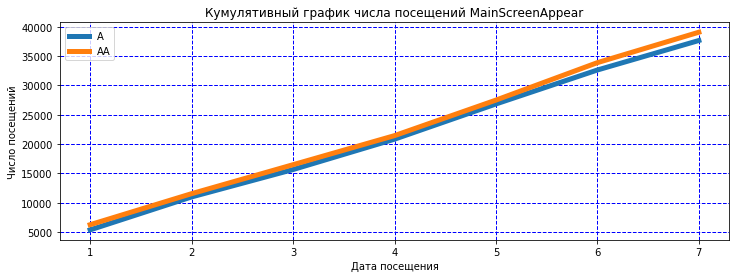

In [262]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.subplots(figsize=(12, 4))
plt.title('Кумулятивный график числа посещений MainScreenAppear')
plt.ylabel('Число посещений')
plt.xlabel('Дата посещения')
plt.plot(data_AA_test['date'], data_AA_test['mainCummulativeA'], label='A', linewidth = 5)
plt.plot(data_AA_test['date'], data_AA_test['mainCummulativeC'], label='AA', linewidth = 5)
plt.grid(color = 'blue', linewidth = 1, linestyle = '--')
plt.legend();

Кумулятивные значения числа посещений MainScreenAppear практически одинаковы до 5-го дня, дальше идет небольшое превышение контрольной группы А

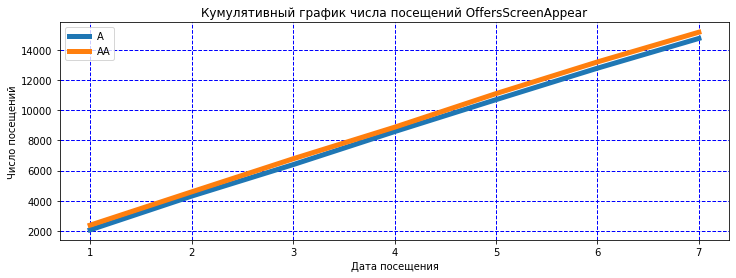

In [263]:
plt.subplots(figsize=(12, 4))
plt.title('Кумулятивный график числа посещений OffersScreenAppear')
plt.ylabel('Число посещений')
plt.xlabel('Дата посещения')
plt.plot(data_AA_test['date'], data_AA_test['offersCummulativeA'], label='A', linewidth = 5)
plt.plot(data_AA_test['date'], data_AA_test['offersCummulativeC'], label='AA', linewidth = 5)
plt.grid(color = 'blue', linewidth = 1, linestyle = '--')
plt.legend();

Кумулятивные значения числа посещений OffersScreenAppear практически одинаковы на всем интервале наблюдений

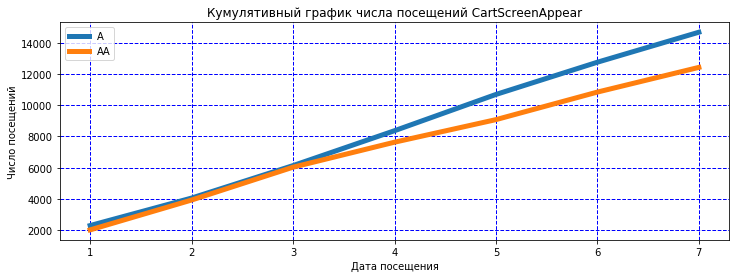

In [264]:
plt.subplots(figsize=(12, 4))
plt.title('Кумулятивный график числа посещений CartScreenAppear')
plt.ylabel('Число посещений')
plt.xlabel('Дата посещения')
plt.plot(data_AA_test['date'], data_AA_test['cartCummulativeA'], label='A', linewidth = 5)
plt.plot(data_AA_test['date'], data_AA_test['cartCummulativeC'], label='AA', linewidth = 5)
plt.grid(color = 'blue', linewidth = 1, linestyle = '--')
plt.legend();

Кумулятивные значения числа посещений CartScreenAppear практически одинаковы до 3-го дня, дальше идет превышение группы А над контрольной группой А

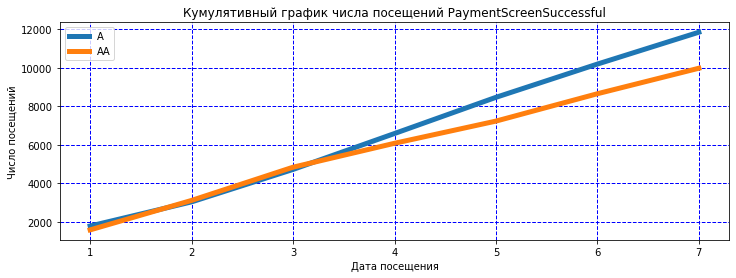

In [265]:
plt.subplots(figsize=(12, 4))
plt.title('Кумулятивный график числа посещений PaymentScreenSuccessful')
plt.ylabel('Число посещений')
plt.xlabel('Дата посещения')
plt.plot(data_AA_test['date'], data_AA_test['paymentCummulativeA'], label='A', linewidth = 5)
plt.plot(data_AA_test['date'], data_AA_test['paymentCummulativeC'], label='AA', linewidth = 5)
plt.grid(color = 'blue', linewidth = 1, linestyle = '--')
plt.legend();

Кумулятивные значения числа посещений PaymentScreenSuccessful практически одинаковы до 3-го дня, дальше идет превышение группы А над контрольной группой А

### Проверим, имеется ли различия в конверсии групп A и контрольной группы А для OffersScreenAppear

In [266]:
offersByUsersA = offers_A['device_id_hash'].value_counts().reset_index()
offersByUsersA.columns = ['userId', 'orders']

In [267]:
offersByUsersC = offers_C['device_id_hash'].value_counts().reset_index()
offersByUsersC.columns = ['userId', 'orders']

In [268]:
sampleAmain = pd.concat([offersByUsersA['orders'],pd.Series(
    0, index=np.arange(data_AA_test['mainPerDateA'].sum() - len(offersByUsersA['orders'])), name='orders')],axis=0)

In [269]:
sampleCmain = pd.concat([offersByUsersC['orders'],pd.Series(
    0, index=np.arange(data_AA_test['mainPerDateC'].sum() - len(offersByUsersC['orders'])), name='orders')],axis=0)

Применим статистический критерий Манна-Уитни к полученным выборкам:

Определим насколько два независимых распределения совпадают.

<b>Нулевая гипотеза:</b>  Распределение признака в первой выборке группы A соответствует распределению признака во второй выборке контрольной группы А для события OffersScreenAppear.

<b>Альтернативная гипотеза:</b>  Распределение признака в первой выборке группы A <b>не</b> соответствует распределению признака во второй выборке контрольной группы А для события OffersScreenAppear.

In [270]:
print("{0:.5f}".format(stats.mannwhitneyu(sampleAmain, sampleCmain)[1]))

0.07347


P-value значительно больше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, не отвергаем. Группы одинаковы, разницы между ними нет, переход на экран предложений идентичен.

Вывод: По «сырым» данным различий в конверсии групп A и контрольной группы А нет.

In [271]:
print("{0:.3f}".format(sampleCmain.mean() / sampleAmain.mean() - 1))

-0.009


Среднее значение числа пользователей перешедших на OffersScreenAppear практически идентично.

### Проверим, имеется ли различия в конверсии групп A и контрольной группы А для CartScreenAppear

In [272]:
cartByUsersA = cart_A['device_id_hash'].value_counts().reset_index()
cartByUsersA.columns = ['userId', 'orders']

In [273]:
cartByUsersC = cart_C['device_id_hash'].value_counts().reset_index()
cartByUsersC.columns = ['userId', 'orders']

In [274]:
sampleAoffers = pd.concat([cartByUsersA['orders'],pd.Series(
    0, index=np.arange(data_AA_test['offersPerDateA'].sum() - len(cartByUsersA['orders'])), name='orders')],axis=0)

In [275]:
sampleCoffers = pd.concat([cartByUsersC['orders'],pd.Series(
    0, index=np.arange(data_AA_test['offersPerDateC'].sum() - len(cartByUsersC['orders'])), name='orders')],axis=0)

Определим насколько два независимых распределения совпадают.

<b>Нулевая гипотеза:</b>  Распределение признака в первой выборке группы A соответствует распределению признака во второй выборке контрольной группы А для события CartScreenAppear.

<b>Альтернативная гипотеза:</b>  Распределение признака в первой выборке группы A <b>не</b> соответствует распределению признака во второй выборке контрольной группы А для события CartScreenAppear.

In [276]:
print("{0:.5f}".format(stats.mannwhitneyu(sampleAoffers, sampleCoffers)[1]))

0.09025


P-value значительно больше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, не отвергаем. Группы одинаковы, разницы между ними нет, заход для CartScreenAppear идентичен.

Вывод: По «сырым» данным различий в конверсии групп A и контрольной группы А нет.

In [277]:
print("{0:.3f}".format(sampleCoffers.sum() / sampleAoffers.sum() - 1))

-0.154


Среднее значение числа пользователей перешедших на CartScreenAppear уменьшилось на 15%.

### Проверим, имеется ли различия в конверсии групп A и контрольной группы А для PaymentScreenSuccessful

In [278]:
paymentByUsersA = payment_A['device_id_hash'].value_counts().reset_index()
paymentByUsersA.columns = ['userId', 'orders']

In [279]:
paymentByUsersC = payment_C['device_id_hash'].value_counts().reset_index()
paymentByUsersC.columns = ['userId', 'orders']

In [280]:
sampleAcart = pd.concat([paymentByUsersA['orders'],pd.Series(
    0, index=np.arange(data_AA_test['cartPerDateC'].sum() - len(paymentByUsersA['orders'])), name='orders')],axis=0)

In [281]:
sampleCcart = pd.concat([paymentByUsersC['orders'],pd.Series(0, index=np.arange(
    data_AA_test['cartPerDateC'].sum() - len(paymentByUsersC['orders'])), name='orders')],axis=0)

Определим насколько два независимых распределения совпадают.

<b>Нулевая гипотеза:</b>  Распределение признака в первой выборке группы A соответствует распределению признака во второй выборке контрольной группы А для события PaymentScreenSuccessful.

<b>Альтернативная гипотеза:</b>  Распределение признака в первой выборке группы A <b>не</b> соответствует распределению признака во второй выборке контрольной группы А для события PaymentScreenSuccessful.

In [282]:
print("{0:.5f}".format(stats.mannwhitneyu(sampleAcart, sampleCcart)[1]))

0.16978


P-value значительно больше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, не отвергаем. Группы одинаковы, разницы между ними нет, заход для PaymentScreenSuccessful идентичен.

Вывод: По «сырым» данным различий в конверсии групп A и контрольной группы А нет.

In [283]:
print("{0:.3f}".format(sampleCcart.mean() / sampleAcart.mean() - 1))

-0.158


Среднее значение числа пользователей перешедших на PaymentScreenSuccessful уменьшилось на 15%.

### Проверим, будет ли отличие между группами статистически достоверным с группой с изменённым шрифтом. Сравним результаты с каждой из контрольных групп в отдельности по каждому событию. Сравним результаты с объединённой контрольной группой.

Сделаем выборку по группе А (246) и MainScreenAppear, добавим кумулятивные метрики

In [284]:
main_B = data_AB.query('exp_id == 248 and event_name == "MainScreenAppear"')

In [285]:
mainBDaily = main_B.pivot_table(index="event_time_day", values="device_id_hash", aggfunc = 'count').reset_index()
mainBDaily.columns = ['date', 'mainPerDateB']

In [286]:
mainBCummulative = mainBDaily.apply(
    lambda x: mainBDaily[mainBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'mainPerDateB': 'sum'}
    ),
    axis=1,
)
mainBCummulative.columns = ['date', 'mainCummulativeB']

Сделаем выборку по группе B (248) и OffersScreenAppear, добавим кумулятивные метрики

In [287]:
offers_B = data_AB.query('exp_id == 248 and event_name == "OffersScreenAppear"')

In [288]:
offersBDaily = offers_B.pivot_table(index="event_time_day", values="device_id_hash", aggfunc = 'count').reset_index()
offersBDaily.columns = ['date', 'offersPerDateB']

In [289]:
offersBCummulative = offersBDaily.apply(
    lambda x: offersBDaily[offersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'offersPerDateB': 'sum'}
    ),
    axis=1,
)
offersBCummulative.columns = ['date', 'offersCummulativeB']

Сделаем выборку по группе B (248) и CartScreenAppear, добавим кумулятивные метрики

In [290]:
cart_B = data_AB.query('exp_id == 248 and event_name == "CartScreenAppear"')

In [291]:
cartBDaily = cart_B.pivot_table(index="event_time_day", values="device_id_hash", aggfunc = 'count').reset_index()
cartBDaily.columns = ['date', 'cartPerDateB']

In [292]:
cartBCummulative = cartBDaily.apply(
    lambda x: cartBDaily[cartBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'cartPerDateB': 'sum'}
    ),
    axis=1,
)
cartBCummulative.columns = ['date', 'cartCummulativeB']

Сделаем выборку по группе B (248) и PaymentScreenSuccessful, добавим кумулятивные метрики

In [293]:
payment_B = data_AB.query('exp_id == 248 and event_name == "PaymentScreenSuccessful"')

In [294]:
paymentBDaily = payment_B.pivot_table(index="event_time_day", values="device_id_hash", aggfunc = 'count').reset_index()
paymentBDaily.columns = ['date', 'paymentPerDateB']

In [295]:
paymentBCummulative = paymentBDaily.apply(
    lambda x: paymentBDaily[paymentBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'paymentPerDateB': 'sum'}
    ),
    axis=1,
)
paymentBCummulative.columns = ['date', 'paymentCummulativeB']

Объединим данные в один датасет

In [296]:
data_AB_test = (mainADaily
    .merge(mainBDaily, left_on='date', right_on='date', how='left')
    .merge(mainACummulative, left_on='date', right_on='date', how='left')
    .merge(mainBCummulative, left_on='date', right_on='date', how='left')
                
    .merge(offersADaily, left_on='date', right_on='date', how='left')
    .merge(offersBDaily, left_on='date', right_on='date', how='left')
    .merge(offersACummulative, left_on='date', right_on='date', how='left')
    .merge(offersBCummulative, left_on='date', right_on='date', how='left')                
                                       
    .merge(cartADaily, left_on='date', right_on='date', how='left')
    .merge(cartBDaily, left_on='date', right_on='date', how='left')
    .merge(cartACummulative, left_on='date', right_on='date', how='left')
    .merge(cartBCummulative, left_on='date', right_on='date', how='left')
                
    .merge(paymentADaily, left_on='date', right_on='date', how='left')
    .merge(paymentBDaily, left_on='date', right_on='date', how='left')
    .merge(paymentACummulative, left_on='date', right_on='date', how='left')
    .merge(paymentBCummulative, left_on='date', right_on='date', how='left')
)

In [297]:
data_AB_test

,date,mainPerDateA,mainPerDateB,mainCummulativeA,mainCummulativeB,offersPerDateA,offersPerDateB,offersCummulativeA,offersCummulativeB,cartPerDateA,cartPerDateB,cartCummulativeA,cartCummulativeB,paymentPerDateA,paymentPerDateB,paymentCummulativeA,paymentCummulativeB
0,1,5370,6319,5370,6319,2062,2550,2062,2550,2287,1921,2287,1921,1785,1401,1785,1401
1,2,5620,5880,10990,12199,2241,2475,4303,5025,1764,2843,4051,4764,1255,2362,3040,3763
2,3,4671,5219,15661,17418,2088,2513,6391,7538,2082,2185,6133,6949,1685,1709,4725,5472
3,4,5178,5067,20839,22485,2191,2201,8582,9739,2238,2314,8371,9263,1865,1876,6590,7348
4,5,6010,5933,26849,28418,2120,2316,10702,12055,2327,2473,10698,11736,1880,1992,8470,9340
5,6,5795,6577,32644,34995,2090,2340,12792,14395,2068,1897,12766,13633,1727,1482,10197,10822
6,7,5032,5567,37676,40562,1975,1992,14767,16387,1924,1546,14690,15179,1655,1263,11852,12085


Построим кумулятивные графики

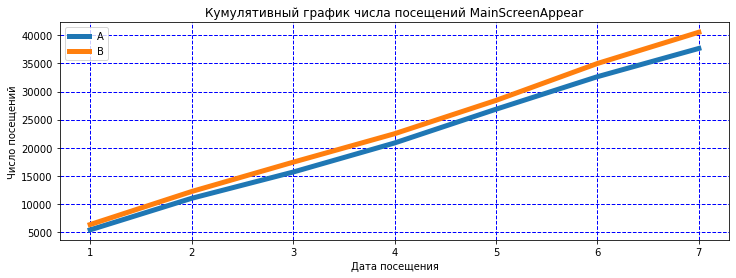

In [298]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.subplots(figsize=(12, 4))
plt.title('Кумулятивный график числа посещений MainScreenAppear')
plt.ylabel('Число посещений')
plt.xlabel('Дата посещения')
plt.plot(data_AB_test['date'], data_AB_test['mainCummulativeA'], label='A', linewidth = 5)
plt.plot(data_AB_test['date'], data_AB_test['mainCummulativeB'], label='B', linewidth = 5)
plt.grid(color = 'blue', linewidth = 1, linestyle = '--')
plt.legend();

Кумулятивные значения числа посещений MainScreenAppear группы В немного превышают на всем исследуемом интервале

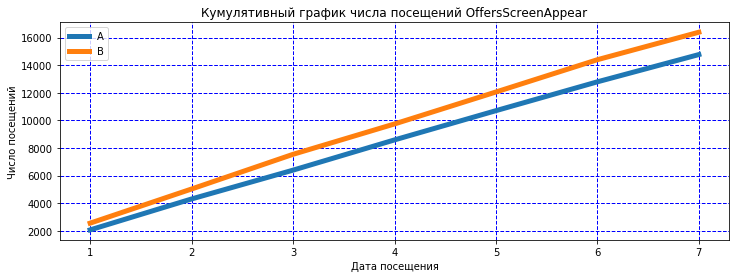

In [299]:
plt.subplots(figsize=(12, 4))
plt.title('Кумулятивный график числа посещений OffersScreenAppear')
plt.ylabel('Число посещений')
plt.xlabel('Дата посещения')
plt.plot(data_AB_test['date'], data_AB_test['offersCummulativeA'], label='A', linewidth = 5)
plt.plot(data_AB_test['date'], data_AB_test['offersCummulativeB'], label='B', linewidth = 5)
plt.grid(color = 'blue', linewidth = 1, linestyle = '--')
plt.legend();

Кумулятивные значения числа посещений OffersScreenAppear группы В плавно увеличиваются на всем интервале

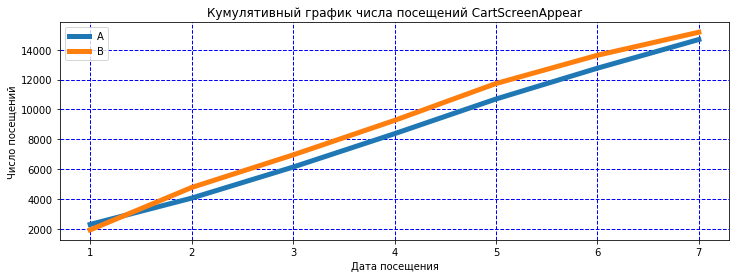

In [300]:
plt.subplots(figsize=(12, 4))
plt.title('Кумулятивный график числа посещений CartScreenAppear')
plt.ylabel('Число посещений')
plt.xlabel('Дата посещения')
plt.plot(data_AB_test['date'], data_AB_test['cartCummulativeA'], label='A', linewidth = 5)
plt.plot(data_AB_test['date'], data_AB_test['cartCummulativeB'], label='B', linewidth = 5)
plt.grid(color = 'blue', linewidth = 1, linestyle = '--')
plt.legend();

Кумулятивные значения числа посещений CartScreenAppear группы В в первый день меньше, затем превышает значения группы А и в последний день значения практически равны

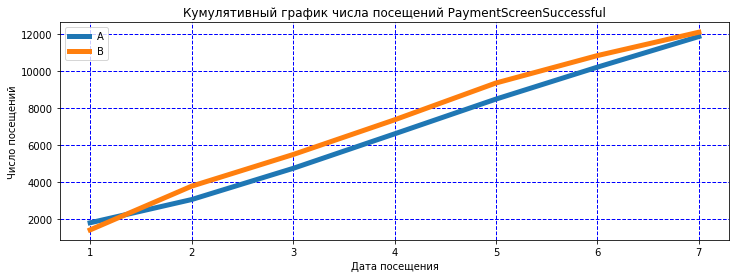

In [301]:
plt.subplots(figsize=(12, 4))
plt.title('Кумулятивный график числа посещений PaymentScreenSuccessful')
plt.ylabel('Число посещений')
plt.xlabel('Дата посещения')
plt.plot(data_AB_test['date'], data_AB_test['paymentCummulativeA'], label='A', linewidth = 5)
plt.plot(data_AB_test['date'], data_AB_test['paymentCummulativeB'], label='B', linewidth = 5)
plt.grid(color = 'blue', linewidth = 1, linestyle = '--')
plt.legend();

Кумулятивные значения числа посещений PaymentScreenSuccessful группы В в первый день меньше, затем превышает значения группы А и в последний день значения практически равны

### Проверим, имеется ли различия в конверсии групп A и группы B для OffersScreenAppear

Поскольку тестов (и гипотез) у нас три, приведем коррекцию уровня значимости

In [302]:
alpha = 0.05
alpha = alpha / 3
alpha

0.016666666666666666

In [303]:
offersByUsersB = offers_B['device_id_hash'].value_counts().reset_index()
offersByUsersB.columns = ['userId', 'orders']

In [304]:
sampleBmain = pd.concat([offersByUsersB['orders'],pd.Series(0, index=np.arange(
    data_AB_test['mainPerDateB'].sum() - len(offersByUsersB['orders'])), name='orders')],axis=0)

Определим насколько два независимых распределения совпадают.

<b>Нулевая гипотеза:</b>  Распределение признака в первой выборке группы A соответствует распределению признака во второй выборке группы В для события OffersScreenAppear.

<b>Альтернативная гипотеза:</b>  Распределение признака в первой выборке группы A <b>не</b> соответствует распределению признака во второй выборке контрольной группы А для события OffersScreenAppear.

In [305]:
print("{0:.5f}".format(stats.mannwhitneyu(sampleAmain, sampleBmain)[1]))

0.01079


P-value значительно больше 0.0167. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, не отвергаем. Группы одинаковы, разницы между ними нет, заход для OffersScreenAppear идентичен.

Вывод: По «сырым» данным различий в конверсии групп A и группы В нет.

In [306]:
print("{0:.3f}".format(sampleBmain.mean() / sampleAmain.mean() - 1))

0.031


Среднее значение числа пользователей перешедших на OffersScreenAppear увеличилось на 3%.

### Проверим, имеется ли различия в конверсии групп A и группы B для CartScreenAppear

In [307]:
cartByUsersB = cart_B['device_id_hash'].value_counts().reset_index()
cartByUsersB.columns = ['userId', 'orders']

In [308]:
sampleBoffers = pd.concat([cartByUsersB['orders'],pd.Series(0, index=np.arange(
    data_AB_test['offersPerDateB'].sum() - len(cartByUsersB['orders'])), name='orders')],axis=0)

Определим насколько два независимых распределения совпадают.

<b>Нулевая гипотеза:</b>  Распределение признака в первой выборке группы A соответствует распределению признака во второй выборке группы В для события CartScreenAppear.

<b>Альтернативная гипотеза:</b>  Распределение признака в первой выборке группы A <b>не</b> соответствует распределению признака во второй выборке контрольной группы А для события CartScreenAppear.

In [309]:
print("{0:.5f}".format(stats.mannwhitneyu(sampleAoffers, sampleBoffers)[1]))

0.00036


P-value значительно меньше 0.0167. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, отвергаем. Группы различны, разницы между ними есть, заход на CartScreenAppear не идентичен.

Вывод: По «сырым» данным есть различия в конверсии групп A и группы В.

In [310]:
print("{0:.3f}".format(sampleBoffers.sum() / sampleAoffers.sum() - 1))

0.033


Среднее значение числа пользователей перешедших на CartScreenAppear увеличилось на 3%.

Посмотрим есть ли выбросы в данных и как они влияют на результат

In [311]:
data_cart_B_count = cart_B['device_id_hash'].value_counts().reset_index()

In [312]:
data_cart_B_count

,index,device_id_hash
0,6304868067479728361,1100
1,6932517045703054087,417
2,4713748699910253089,376
3,2305766456715991733,319
4,1100007125648169445,311
...,...,...
1225,975074959546731393,1
1226,4369662623769092250,1
1227,1534901408177518994,1
1228,8108627213949746289,1


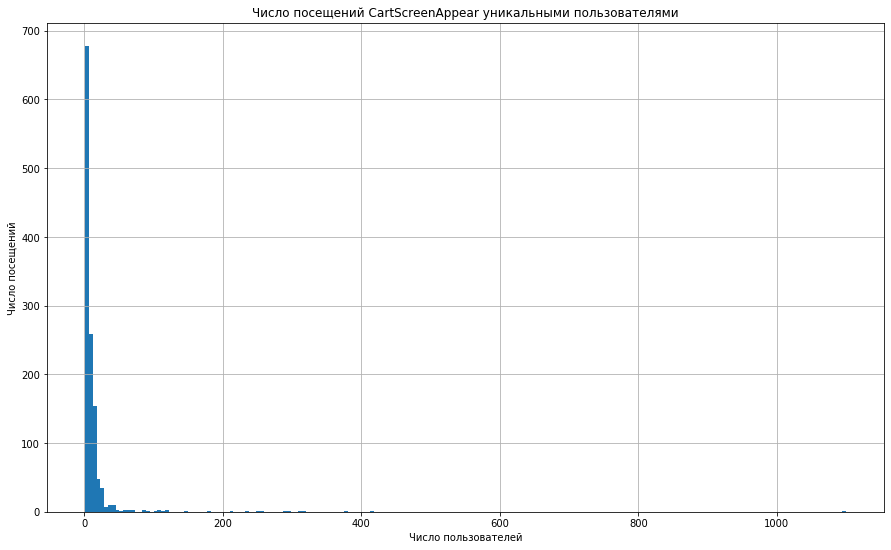

In [313]:
data_cart_B_count.hist('device_id_hash', bins=200, figsize=(15, 9))
plt.title('Число посещений CartScreenAppear уникальными пользователями')
plt.ylabel('Число посещений')
plt.xlabel('Число пользователей');

Большие выбросы значений

In [314]:
device_id_hash_cart = data_cart_B_count.loc[:, ['device_id_hash']]

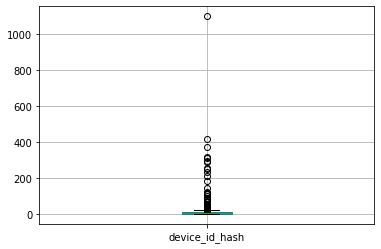

In [315]:
device_id_hash_cart.boxplot();

In [316]:
device_id_hash_cart.describe()

,device_id_hash
count,1230.000000
mean,12.340650
std,42.860459
min,1.000000
25%,3.000000
50%,6.000000
75%,11.000000
max,1100.000000


Среднее значение числа посещений 12, медианное 6, максимальное 1230

Посмотрим на распределение значений 95%

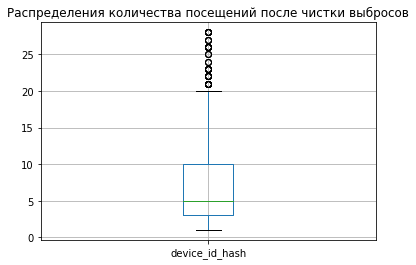

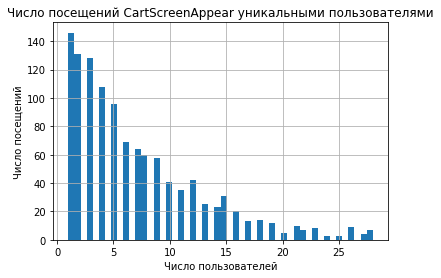

In [317]:
p95 = device_id_hash_cart.describe(percentiles = [0.01, 0.5, 0.95]).T['95%']['device_id_hash']
df_new = device_id_hash_cart.query('device_id_hash <= @p95')
plt.title('Распределения количества посещений после чистки выбросов')
df_new.boxplot()
plt.show()
df_new['device_id_hash'].hist(bins=50)
plt.title('Число посещений CartScreenAppear уникальными пользователями')
plt.ylabel('Число посещений')
plt.xlabel('Число пользователей');
plt.show()

Принимаем значение 95% для дальнейшего анализа

In [318]:
print(np.percentile(data_cart_B_count['device_id_hash'], [90, 95, 99])) 

[ 19.    28.   138.75]


In [319]:
usersWithManyOrders_AB = pd.concat(
    [
        cartByUsersA[cartByUsersA['orders'] > 28]['userId'],
        cartByUsersB[cartByUsersB['orders'] > 28]['userId'],
    ],
    axis=0,
)
#usersWithManyOrders_AB

In [320]:
abnormalUsers_AB = (
    pd.concat([usersWithManyOrders_AB], axis=0)
    .drop_duplicates()
    .sort_values()
)

In [321]:
sampleAFiltered_cart = pd.concat(
    [
        cartByUsersA[
            np.logical_not(cartByUsersA['userId'].isin(abnormalUsers_AB))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data_AB_test['offersPerDateA'].sum() - len(cartByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered_cart = pd.concat(
    [
        cartByUsersB[
            np.logical_not(cartByUsersB['userId'].isin(abnormalUsers_AB))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data_AB_test['offersPerDateB'].sum() - len(cartByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [322]:
print('{0:.5f}'.format(stats.mannwhitneyu(sampleAFiltered_cart, sampleBFiltered_cart)[1]))

0.00244


P-value значительно меньше 0.0167. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, отвергаем. Группы различны, разницы между ними есть, заход на CartScreenAppear не идентичен.

Вывод: По «очищенным» данным есть различия в конверсии групп A и группы В.

### Проверим, имеется ли различия в конверсии групп A и группы B для PaymentScreenSuccessful

In [323]:
paymentByUsersB = payment_B['device_id_hash'].value_counts().reset_index()
paymentByUsersB.columns = ['userId', 'orders']

In [324]:
sampleBcart = pd.concat([paymentByUsersB['orders'],pd.Series(
    0, index=np.arange(data_AB_test['cartPerDateB'].sum() - len(paymentByUsersB['orders'])), name='orders')],axis=0)

Определим насколько два независимых распределения совпадают.

<b>Нулевая гипотеза:</b>  Распределение признака в первой выборке группы A соответствует распределению признака во второй выборке группы В для события PaymentScreenSuccessful.

<b>Альтернативная гипотеза:</b>  Распределение признака в первой выборке группы A <b>не</b> соответствует распределению признака во второй выборке контрольной группы А для события PaymentScreenSuccessful.

In [325]:
print("{0:.5f}".format(stats.mannwhitneyu(sampleAcart, sampleBcart)[1]))

0.00000


P-value значительно меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, отвергаем. Группы различны, разницы между ними есть, заход на PaymentScreenSuccessful не идентичен.

Вывод: По «сырым» данным есть различия в конверсии групп A и группы В.

In [326]:
print("{0:.3f}".format(sampleBcart.sum() / sampleAcart.sum() - 1))

0.020


Среднее значение числа пользователей перешедших на PaymentScreenSuccessful увеличилось на 2%

Посмотрим есть ли выбросы в данных и как они влияют на результат

In [327]:
data_payment_B_count = payment_B['device_id_hash'].value_counts().reset_index()

In [328]:
print(np.percentile(data_payment_B_count['device_id_hash'], [90, 95, 99])) 

[ 15.   21.  122.6]


In [329]:
usersWithManypayment_AB = pd.concat(
    [
        cartByUsersA[cartByUsersA['orders'] > 21]['userId'],
        cartByUsersB[cartByUsersB['orders'] > 21]['userId'],
    ],
    axis=0,
)
#usersWithManypayment_AB

In [330]:
abnormalUsers_AB_payment = (
    pd.concat([usersWithManypayment_AB], axis=0)
    .drop_duplicates()
    .sort_values()
)

In [331]:
sampleAFiltered_payment = pd.concat(
    [
        paymentByUsersA[
            np.logical_not(paymentByUsersA['userId'].isin(abnormalUsers_AB_payment))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data_AB_test['cartPerDateA'].sum() - len(paymentByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered_payment = pd.concat(
    [
        cartByUsersB[
            np.logical_not(cartByUsersB['userId'].isin(abnormalUsers_AB_payment))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data_AB_test['cartPerDateB'].sum() - len(cartByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [332]:
print('{0:.5f}'.format(stats.mannwhitneyu(sampleAFiltered_payment, sampleBFiltered_payment)[1]))

0.32074


P-value значительно больше 0.0167. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, не отвергаем. Группы одинаковы, разницы между ними нет, заход для PaymentScreenSuccessful идентичен.

Вывод: По «очищенным» данным различий в конверсии групп A и группы В нет.

Мы приняли уровень статистической значимости для для нашего теста в 5%.
В начале п. 24 мы приняли коррекцию уровня значимости наших гипотез. Поскольку мы применили одновременно 3 теста, то уровень статистической значимости alpha был выбран 0.0167 или 0.05/3.

# Шаг 6. Сформулируем выводы и рекомендации

<div class="alert alert-info" role="alert">

Мы разобрались, как ведут себя пользователи мобильного приложения в стартапе, который продаёт продукты питания.
Для этого мы изучили воронку продаж и узнали, как пользователи доходят до покупки, сколько пользователей доходят до покупки, а сколько — «застревает» на предыдущих шагах.
    
<b>Шаг 1.  Открыли файл с данными и изучили общую информацию</b>

<b>Шаг 2. Подготовили данные</b>
    
Заменили названия столбцов;
    
Проверили пропуски и типы данных;
    
Добавили столбец даты и времени, а также отдельный столбец дат;    

<b>Шаг 3. Изучили и проверили данные</b>    

Ответили на следующие вопросы:
    
Сколько всего событий в логе
    
Сколько всего пользователей в логе
    
Сколько в среднем событий приходится на пользователя
    
Определили за какой период мы располагаем данными. Нашли максимальную и минимальную дату. Построили гистограмму по дате и времени. 
Определили, с какого момента данные полные и отбросили более старые.
    
Определили сколько событий и пользователей мы потеряли, отбросив старые данные.
Проверили, что у нас есть пользователи из всех трёх экспериментальных групп.    
    
<b>Шаг 4. Изучили воронку событий</b>    
    
Посмотрели, какие события есть в логах, как часто они встречаются. Отсортировали события по частоте.
    
Посчитали, сколько пользователей совершали каждое из этих событий. Отсортировали события по числу пользователей. Посчитали долю пользователей, которые хоть раз совершали событие.
    
Предположили, в каком порядке происходят события.
    
По воронке событий посчитали, какая доля пользователей проходит на следующий шаг воронки.
    
Определили на каком шаге теряется больше всего пользователей.
    
Определили какая доля пользователей доходит от первого события до оплаты.
        
<b>Шаг 5. Изучили результаты эксперимента</b>   
       
Определили сколько пользователей в каждой экспериментальной группе.
    
Проверили, находят ли статистические критерии разницу между выборками 246 и 247.
    
Выбрали самое популярное событие. Посчитали число пользователей, совершивших это событие в каждой из контрольных групп. 
    
Посчитали долю пользователей, совершивших это событие. Проверили, будет ли отличие между группами статистически достоверным. 
    
Проверили, будет ли отличие между группами статистически достоверным с группой с изменённым шрифтом.
    
Сравнили результаты с каждой из контрольных групп в отдельности по каждому событию. Сравнили результаты с объединённой контрольной группой.
    
Посчитали, сколько проверок статистических гипотез мы сделали.

Построили кумулятивные графики числа событий по каждой группе
     
<b>Шаг 6. Сформулировали общие выводы и рекомендации</b> 
       
Выводы

В датасете 413 дубликатов. Удалим их.
Таблица заполнена полностью. Все столбцы соответствуют своему типу.
Данные представляют собой около 244 тысячи строк.

В нашем датасете всего 243713 события. Из них:

Переход на экран корзины - 42668 события;

Переход на главный экран - 119101 события;

Переход на экран предложений - 46808 события;

Успешное совершение платежа - 34118 события;

Изучение руководства - 1018 событий


Разделенные на 3 группы пользователи совершают примерно равное число событий: Группа А - 80181 событий, контрольная группа А - 77950 событий и группа В - 85582 событий.

Всего у нас 7551 пользователь с числом событий от 1 до 2307.


В среднем на одного пользователя приходится 20 событий, медианное значение составляет 32 события. Скорее всего в данных есть выбросы. Изучим поведения пользователей в дальнейших действиях.

Начало данных с 25 июля 2019 года, окончание 07 августа 2019 года, что составляет 2 недели.

Данные несут периодический характер, прослеживаются циклическая активность связанная с суточной периодичностью (день/ночь). За последний день данные немного урезаны. Посмотрим на дневном графике распределения событий, на сколько у нас меняются эти данные в сутки

У нас представленны данные в основном за 7 дней. За последний день данные немного обрезаны, но это не сильно влияет на суточные показатели активности.

В общей сложности мы отбросили около 3-х тысяч событий, который не попали в наш активный исследуемый период, что составляет 1.2%

Столбец EventName (название события) включает в себя следующие данные:

MainScreenAppear (Переход на главный экран) - 117328 событий;

OffersScreenAppear (Переход на экран предложений) - 46333 событий;

CartScreenAppear (Переход на экран корзины) - 42303 событий;

PaymentScreenSuccessful (Успешное совершение платежа) - 33918 событий;

Tutorial (Руководство) - 1005 событий.



Столбец device_id_nunique включает в себя следующие данные по числу пользователей, которые совершали каждое из этих событий:

MainScreenAppear (Переход на главный экран) - 7419 пользователей;

OffersScreenAppear (Переход на экран предложений) - 4593 пользователей;

CartScreenAppear (Переход на экран корзины) - 3734 пользователей;

PaymentScreenSuccessful (Успешное совершение платежа) - 3539 пользователей;

Tutorial (Руководство) - 840 пользователей.

Доля пользователей, которая хоть раз совершали событие OffersScreenAppear: 61.9%

Доля пользователей, которая хоть раз совершали событие CartScreenAppear: 50.3%

Доля пользователей, которая хоть раз совершали событие PaymentScreenSuccessfulr: 47.7%

Доля пользователей, которая хоть раз совершали событие Tutorial: 11.3%

Последовательность действий для покупки в нашем интернет магазине следующая: Переход на главный экран - Переход на экран предложений - Переход на экран корзины - Успешное совершение платежа.

Событие Tutorial (Руководство) является необязательным для совершения покупки, это те пользователи, которые не смогли интуитивно совершить покупку и прибегли к разъяснениям. мы смело можем исключить из анализа воронки событий.

По уточненным данным для изучения воронки событий мы имеем: датасет data_AB с числом совершенных событий 239882 и числом исследуемых дней -7.

Доля пользователей, которая переходит на OffersScreenApeapr: 61.9%

Доля пользователей, которая переходит на CartScreenAppear: 81.3%

Доля пользователей, которая переходит на PaymentScreenSuccessfulr: 94.8%

Больше всего пользователей теряется на первом шаге, то есть при заходе на главную страницу только 61.9% пользователей переходят к выбору товаров. После выбора товаров 81.3% пользователей переходят в корзину оплаты товаров. И из корзины оплаты товаров 94.8% производят ее оплату.

Доля пользователей, которая доходит от первого события до оплаты: 47.7%

Данные по группам на первый взгляд сбалансированы: Число пользователей из группы А - 78985 человек; Число пользователей из контрольной группы А - 76684 человек; Число пользователей из группы В - 84213 человек.

Проверили распределение по группам 
Вероятность попасть в группу А составила около 50%. Проверили каждое событие одновыборочным z-тестом:
Все нулевые гипотезы не отвергаелись: вероятность попасть в группу А составляет 50%

Кумулятивные значения числа посещений MainScreenAppear практически одинаковы до 5-го дня, дальше идет небольшое превышение контрольной группы А

Кумулятивные значения числа посещений OffersScreenAppear практически одинаковы на всем интервале наблюдений

Кумулятивные значения числа посещений CartScreenAppear практически одинаковы до 3-го дня, дальше идет превышение группы А над контрольной группой А

Кумулятивные значения числа посещений PaymentScreenSuccessful практически одинаковы до 3-го дня, дальше идет превышение группы А над контрольной группой А

Применим статистический критерий Манна-Уитни к полученным выборкам:

АА тест:
Для события OffersScreenAppear:
P-value значительно больше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, не отвергаем. Группы одинаковы, разницы между ними нет, заход на главную страницу идентичен.
Вывод: По «сырым» данным различий в конверсии групп A и контрольной группы А нет.
Среднее значение числа пользователей перешедших на OffersScreenAppear практически идентично.

Для события CartScreenAppear:
P-value значительно больше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, не отвергаем. Группы одинаковы, разницы между ними нет, заход для CartScreenAppear идентичен.
Вывод: По «сырым» данным различий в конверсии групп A и контрольной группы А нет.
Среднее значение числа пользователей перешедших на CartScreenAppear уменьшилось на 15%.

Для события PaymentScreenSuccessful:
P-value значительно больше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, не отвергаем. Группы одинаковы, разницы между ними нет, заход для PaymentScreenSuccessful идентичен.
Вывод: По «сырым» данным различий в конверсии групп A и контрольной группы А нет.
Среднее значение числа пользователей перешедших на PaymentScreenSuccessful уменьшилось на 15%.

АВ тест:

Кумулятивные значения числа посещений MainScreenAppear группы В немного превышают на всем исследуемом интервале

Кумулятивные значения числа посещений OffersScreenAppear группы В плавно увеличиваются на всем интервале

Кумулятивные значения числа посещений CartScreenAppear группы В в первый день меньше, затем превышает значения группы А и в последний день значения практически равны

Кумулятивные значения числа посещений PaymentScreenSuccessful группы В в первый день меньше, затем превышает значения группы А и в последний день значения практически равны

Для события OffersScreenAppear:
P-value значительно больше 0.0167. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, не отвергаем. Группы одинаковы, разницы между ними нет, заход для OffersScreenAppear идентичен.
Вывод: По «сырым» данным различий в конверсии групп A и группы В нет.
Среднее значение числа пользователей перешедших на OffersScreenAppear увеличилось на 3%.

Для события CartScreenAppear:
P-value значительно меньше 0.0167. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, отвергаем. Группы различны, разницы между ними есть, заход на CartScreenAppear не идентичен.
Вывод: По «сырым» данным есть различия в конверсии групп A и группы В.
Среднее значение числа пользователей перешедших на CartScreenAppear увеличилось на 3%.
Вывод: По «очищенным» данным есть различия в конверсии групп A и группы В.

Для события PaymentScreenSuccessful:
P-value значительно меньше 0.0167. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, отвергаем. Группы различны, разницы между ними есть, заход на PaymentScreenSuccessful не идентичен.
Вывод: По «сырым» данным есть различия в конверсии групп A и группы В.
Среднее значение числа пользователей перешедших на PaymentScreenSuccessful увеличилось на 2%
Вывод: По «очищенным» данным различий в конверсии групп A и группы В нет. 
    
    
<b>Изменение шрифта в мобильном приложении:<b>
Изменение шрифта в мобильном приложении влияет на переход пользователей на экран корзины и среднее увеличение числа пользователей составляет около 3%. Поскольку 94.8% пользователей далее совершают покупку, то можно сказать, что изменение шрифта в мобильном приложении увеличивает долю продаж около 3%. Результат теста можно признать успешным и внедрять новые шрифты в мобильном приложении.
    
</div>        